# Segmenting and Clustering Neighborhoods in the City of Toronto, Canada

This notebook presents my work in segmenting and clustering Toronto neighbourhoods with repect to their 10 most popular venues. We begin with importing some of the required libraries.

In [1]:
import numpy as np

import pandas as pd # library for data analsysis

!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup # library for parsing HTML pages

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Bing # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1. Build a Dataframe Containing Toronto Postal Codes, Boroughs and Neighborhoods

As a first step we will get the HTML page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M that contains all the Toronto postal codes with "requests" and read into a BeatifulSoup object.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

As can be seen by the page structure, the table of interest is the first one (index 0). We will extract it from the object.

In [3]:
table = soup.find_all('table')[0]

Next we use the code below to get the table dimensions and extract and clean the data and load it into a data frame complete with column names.

In [4]:
n_columns = 0
n_rows=0
column_names = []
    
# Determine number of rows and columns
for row in table.find_all('tr'):
                
    # Determine the number of rows in the table
    td_tags = row.find_all('td')
    if len(td_tags) > 0:
        n_rows+=1
    # Set the number of columns for table
    n_columns = len(td_tags)
                        
    #Get column names from the table header
    th_tags = row.find_all('th') 
    if len(th_tags) > 0:
        for th in th_tags:
            column_names.append(th.get_text().replace('\n','')) # Get column names and strip the line breaks '\n'
            
# Set up the data frame 
df = pd.DataFrame(columns = column_names,
                    index= range(0,n_rows))

# Get content cell by call and fill data frame
row_marker = 0
for row in table.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        df.iat[row_marker,column_marker] = column.get_text().replace('\n','') # Get cell content and strip the line breaks '\n'
        column_marker += 1
    if len(columns) > 0:
        row_marker += 1

Let's check success:

In [5]:
df.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

Looks good, three columns, as expected. Let's check size:

In [6]:
df.shape

(180, 3)

Again, looks good. Next we need tor remove the rows in the data where the postal code is not assigned, meaning where the borough cell contains the text 'Not assigned'. We do this with a conditional copy.

In [7]:
df2 = df[df.Borough!='Not assigned']

Let's check for success:

In [8]:
df2

Postal Code           Borough  \
2           M3A        North York   
3           M4A        North York   
4           M5A  Downtown Toronto   
5           M6A        North York   
6           M7A  Downtown Toronto   
..          ...               ...   
160         M8X         Etobicoke   
165         M4Y  Downtown Toronto   
168         M7Y      East Toronto   
169         M8Y         Etobicoke   
178         M8Z         Etobicoke   

                                         Neighbourhood  
2                                            Parkwoods  
3                                     Victoria Village  
4                            Regent Park, Harbourfront  
5                     Lawrence Manor, Lawrence Heights  
6          Queen's Park, Ontario Provincial Government  
..                                                 ...  
160      The Kingsway, Montgomery Road, Old Mill North  
165                               Church and Wellesley  
168  Business reply mail Processing Centre, South C...  
169  Old Mill South, King's Mill Park, Sunnylea, Hu...  
178  Mimico NW, The Queensway West, South of Bloor,...  

[103 rows x 3 columns]

Worked, the first two rows that contained 'Not assigned' are not in df2. The next task is to find neighbourhoods that are 'Not assigned' but where borough has a valid value. I don't recall having seen any, but let's make sure. As the data frame consists of only 3 columns, where the first one contains only three-character postal codes, the second can't contain 'Not assigned' because only rows were copied that explicitely did not contain this value. So, if the table still contains 'Not assigned' it can only be in the third column 'Neighbourhood'. We can therefore use a simple test first to see if 'Not assigned' exists in df2 at all: 

In [9]:
'Not assigned' in df2.values

False

'False' means that 'Not assigned' is no longer in the data frame, so we needn't worry about that anymore and can perform the last task of this part, use '.shape' to display the size of the resulting data frame df2. As we can see we have 77 rows less compared to the original data frame df:

In [10]:
df2.shape

(103, 3)

## 2. Add Latitude and Longitude to the Data Frame according to Postal Code

We need latitude and longitude in the data frame to be able to use the Foursquare location data. We begin with resetting the index of df2 in order to be able to properly iterate over the rows.

In [11]:
df2.reset_index(drop=True, inplace=True)

Let's check for success again:

In [12]:
df2.head()

Postal Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

This looks good.

Next we have to add two columns for the latitude and the longitude and then fill those with the values according to the postal code. I tried this  with geocoder and the code snippet provided in the instructions and failed miserably. Next I tried to use other code to acccess the Google geocoder - same result. In the New York neighbourhood clustering lab we used Nominatim. I tried this, it worked but Nimonatim uses the OpenStreetMap database and that seems to be very weak in Toronto data, only every 10th postal code got a return. I got myself and API key for Bing maps, and this worked. 

In [13]:
# Create two new columns and fill them with dummy values
df2.assign(Latitude=0.0, Longitude=0.0)
# Loop over the whole data frame and get latitude and longitude for each postal code and store it in the same row
for m in range(df2.shape[0]):
    address = 'Toronto, Ontario ' + df2.loc[m,'Postal Code']
    geolocator = Bing(api_key='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    location = geolocator.geocode(address)
    df2.loc[m,'Latitude'] = location.latitude
    df2.loc[m,'Longitude'] = location.longitude

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Let's look at the results. Wonderful, definitely beats downloading ready-made CSV files. Some third digit-deviations from the data in that file but more than good enough to be used.

In [14]:
df2

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
..          ...               ...   
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                         Neighbourhood   Latitude  Longitude  
0                                            Parkwoods  43.756123 -79.329636  
1                                     Victoria Village  43.726780 -79.310738  
2                            Regent Park, Harbourfront  43.655354 -79.365044  
3                     Lawrence Manor, Lawrence Heights  43.721996 -79.445915  
4          Queen's Park, Ontario Provincial Government  43.663910 -79.388733  
..                                                 ...        ...        ...  
98       The Kingsway, Montgomery Road, Old Mill North  43.652699 -79.511276  
99                                Church and Wellesley  43.666286 -79.382446  
100  Business reply mail Processing Centre, South C...  43.663506 -79.317429  
101  Old Mill South, King's Mill Park, Sunnylea, Hu...  43.633709 -79.496521  
102  Mimico NW, The Queensway West, South of Bloor,...  43.629711 -79.517479  

[103 rows x 5 columns]

## 3. Explore and Cluster Toronto Neighbourhoods

I decide to follow the suggestion to explore and cluster only the neighbourhoods in the boroughs that contain the name Toronto. As our dataframe df2 contains  the location information with respect to postal codes and some of them may refer to several neighbourhoods, as we can see by inspecting the 'Neighbourhood' column, we need to do some additional processing of this data frame to get to the neighborhood information. In a first step we will extract all rows where the borough name contains 'Toronto' into a new data frame and print the result.

In [15]:
# Select rows where Borough contains 'Toronto' and reset index of new data frame
df3 = df2[df2['Borough'].str.contains('Toronto')]
df3.reset_index(drop=True, inplace=True)
df3

Postal Code           Borough  \
0          M5A  Downtown Toronto   
1          M7A  Downtown Toronto   
2          M5B  Downtown Toronto   
3          M5C  Downtown Toronto   
4          M4E      East Toronto   
5          M5E  Downtown Toronto   
6          M5G  Downtown Toronto   
7          M6G  Downtown Toronto   
8          M5H  Downtown Toronto   
9          M6H      West Toronto   
10         M5J  Downtown Toronto   
11         M6J      West Toronto   
12         M4K      East Toronto   
13         M5K  Downtown Toronto   
14         M6K      West Toronto   
15         M4L      East Toronto   
16         M5L  Downtown Toronto   
17         M4M      East Toronto   
18         M4N   Central Toronto   
19         M5N   Central Toronto   
20         M4P   Central Toronto   
21         M5P   Central Toronto   
22         M6P      West Toronto   
23         M4R   Central Toronto   
24         M5R   Central Toronto   
25         M6R      West Toronto   
26         M4S   Central Toronto   
27         M5S  Downtown Toronto   
28         M6S      West Toronto   
29         M4T   Central Toronto   
30         M5T  Downtown Toronto   
31         M4V   Central Toronto   
32         M5V  Downtown Toronto   
33         M4W  Downtown Toronto   
34         M5W  Downtown Toronto   
35         M4X  Downtown Toronto   
36         M5X  Downtown Toronto   
37         M4Y  Downtown Toronto   
38         M7Y      East Toronto   

                                        Neighbourhood   Latitude  Longitude  
0                           Regent Park, Harbourfront  43.655354 -79.365044  
1         Queen's Park, Ontario Provincial Government  43.663910 -79.388733  
2                            Garden District, Ryerson  43.657478 -79.378632  
3                                      St. James Town  43.651112 -79.375732  
4                                         The Beaches  43.676559 -79.294159  
5                                         Berczy Park  43.647018 -79.374084  
6                                  Central Bay Street  43.656761 -79.386490  
7                                            Christie  43.667717 -79.420197  
8                            Richmond, Adelaide, King  43.649670 -79.382248  
9                        Dufferin, Dovercourt Village  43.665165 -79.437805  
10  Harbourfront East, Union Station, Toronto Islands  43.640686 -79.376625  
11                           Little Portugal, Trinity  43.647423 -79.418037  
12                       The Danforth West, Riverdale  43.678818 -79.351295  
13           Toronto Dominion Centre, Design Exchange  43.648163 -79.381966  
14       Brockton, Parkdale Village, Exhibition Place  43.640450 -79.429131  
15                     India Bazaar, The Beaches West  43.671200 -79.316490  
16                     Commerce Court, Victoria Hotel  43.648781 -79.378960  
17                                    Studio District  43.661816 -79.342186  
18                                      Lawrence Park  43.727158 -79.397041  
19                                           Roselawn  43.710556 -79.419601  
20                                   Davisville North  43.710339 -79.394485  
21    Forest Hill North & West, Forest Hill Road Park  43.695915 -79.412544  
22                      High Park, The Junction South  43.661377 -79.464638  
23                 North Toronto West,  Lawrence Park  43.711758 -79.403847  
24                The Annex, North Midtown, Yorkville  43.673180 -79.401764  
25                             Parkdale, Roncesvalles  43.646893 -79.449150  
26                                         Davisville  43.703209 -79.390472  
27                     University of Toronto, Harbord  43.664673 -79.397194  
28                                 Runnymede, Swansea  43.653214 -79.481972  
29                        Moore Park, Summerhill East  43.687790 -79.388641  
30          Kensington Market, Chinatown, Grange Park  43.653225 -79.397133  
31  Summerhill West, Rathnelly, South Hill, Forest...  43.686405 -

Inspection of the resulting data frame shows that we also have neighbourhoods that have more than one postal code they are therefore duplicates in the data frame column 'Neighbourhood', not a big problem but needs fixing. Therefore we first extract all values the column 'Neighbourhood'. This is the only information we need from df3 because - for one -  we are looking at the neighborhouds and secondly all other information, including latitudes and longitudes refer to the postal codes - we will need new ones anyway.   

In [16]:
# Extract neighbourhoods data
neighbourhoods = df3['Neighbourhood']
# Iterate over the resulting series to split into single neigbourhoods and re-assemble a new object
neighbourhoods2 = []
for m in range(neighbourhoods.shape[0]):
    temp = neighbourhoods[m].split(',')
    neighbourhoods2 = neighbourhoods2 + temp

Let's check results.

In [17]:
neighbourhoods2

['Regent Park',
 ' Harbourfront',
 "Queen's Park",
 ' Ontario Provincial Government',
 'Garden District',
 ' Ryerson',
 'St. James Town',
 'The Beaches',
 'Berczy Park',
 'Central Bay Street',
 'Christie',
 'Richmond',
 ' Adelaide',
 ' King',
 'Dufferin',
 ' Dovercourt Village',
 'Harbourfront East',
 ' Union Station',
 ' Toronto Islands',
 'Little Portugal',
 ' Trinity',
 'The Danforth West',
 ' Riverdale',
 'Toronto Dominion Centre',
 ' Design Exchange',
 'Brockton',
 ' Parkdale Village',
 ' Exhibition Place',
 'India Bazaar',
 ' The Beaches West',
 'Commerce Court',
 ' Victoria Hotel',
 'Studio District',
 'Lawrence Park',
 'Roselawn',
 'Davisville North',
 'Forest Hill North & West',
 ' Forest Hill Road Park',
 'High Park',
 ' The Junction South',
 'North Toronto West',
 '  Lawrence Park',
 'The Annex',
 ' North Midtown',
 ' Yorkville',
 'Parkdale',
 ' Roncesvalles',
 'Davisville',
 'University of Toronto',
 ' Harbord',
 'Runnymede',
 ' Swansea',
 'Moore Park',
 ' Summerhill East',

Not very attractive. Some of the list fields have leading spaces ' ', apart from complicating duplicate search, this will also not look so good if we want to use the neighbourhood names as labels later, so lets remove them first. There are definiteley many ways to solve this task. We will do a type conversion to a pandas series object and apply an 'lstrip' to it, if done without parameters it will remove leading whitespace.

In [18]:
neighbourhoods3 = pd.Series(neighbourhoods2, name='Neighbourhood')
neighbourhoods4 = neighbourhoods3.str.lstrip()
neighbourhoods4.shape

(78,)

So, we have series with 78 elements. No let's remove the duplicates:

In [19]:
neighbourhoods4.drop_duplicates(keep='first', inplace=True)
neighbourhoods4.shape

(76,)

Two duplicates removed, obviously. 76 elements are left. Now we will have to create another data frame with the location data, which of course we will get again courtesy of Microsoft's Bing maps. So let's get started with creating and initializing the data frame, and also not forget to reset the index of the data frame to account for the removed duplicates.

In [20]:
neighbourhoods5 = pd.DataFrame(neighbourhoods4)
neighbourhoods5.assign(Latitude=0.0, Longitude=0.0)
neighbourhoods5.reset_index(drop=True, inplace=True)

So, there we are - new data frame, only for the neighbourhoods, time to assign the geographical coordinates. As before, we will rely on Bing Maps.

In [21]:
# This is pretty much the same code as used previously for the postal code-based coordinate assignment, see above
for m in range(neighbourhoods5.shape[0]):
    address = 'Toronto, Ontario ' + neighbourhoods5.loc[m,'Neighbourhood']
    geolocator = Bing(api_key='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    location = geolocator.geocode(address)
    neighbourhoods5.loc[m,'Latitude'] = location.latitude
    neighbourhoods5.loc[m,'Longitude'] = location.longitude

Let's have a look at what we have produced:

In [22]:
neighbourhoods5.head()

Neighbourhood   Latitude  Longitude
0                    Regent Park  43.660652 -79.360489
1                   Harbourfront  43.639191 -79.384201
2                   Queen's Park  43.663425 -79.391914
3  Ontario Provincial Government  43.651894 -79.381714
4                Garden District  43.658234 -79.377853

This looks fine. Time to create a folium map of Toronto and place circular markers on it to show the locations of the 76 neighbourhoods.

In [23]:
# Get the coordinates of Toronto first to center the map around
address = 'Toronto, Ontario'
geolocator = Bing(api_key='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Create folium map of Toronto with these coordinates
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add markers to map
for lat, lng, neighbourhood in zip(neighbourhoods5['Latitude'], neighbourhoods5['Longitude'], neighbourhoods5['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='lightgreen',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

In case you can't see the trusted notebook, here is an embedded image of the map:

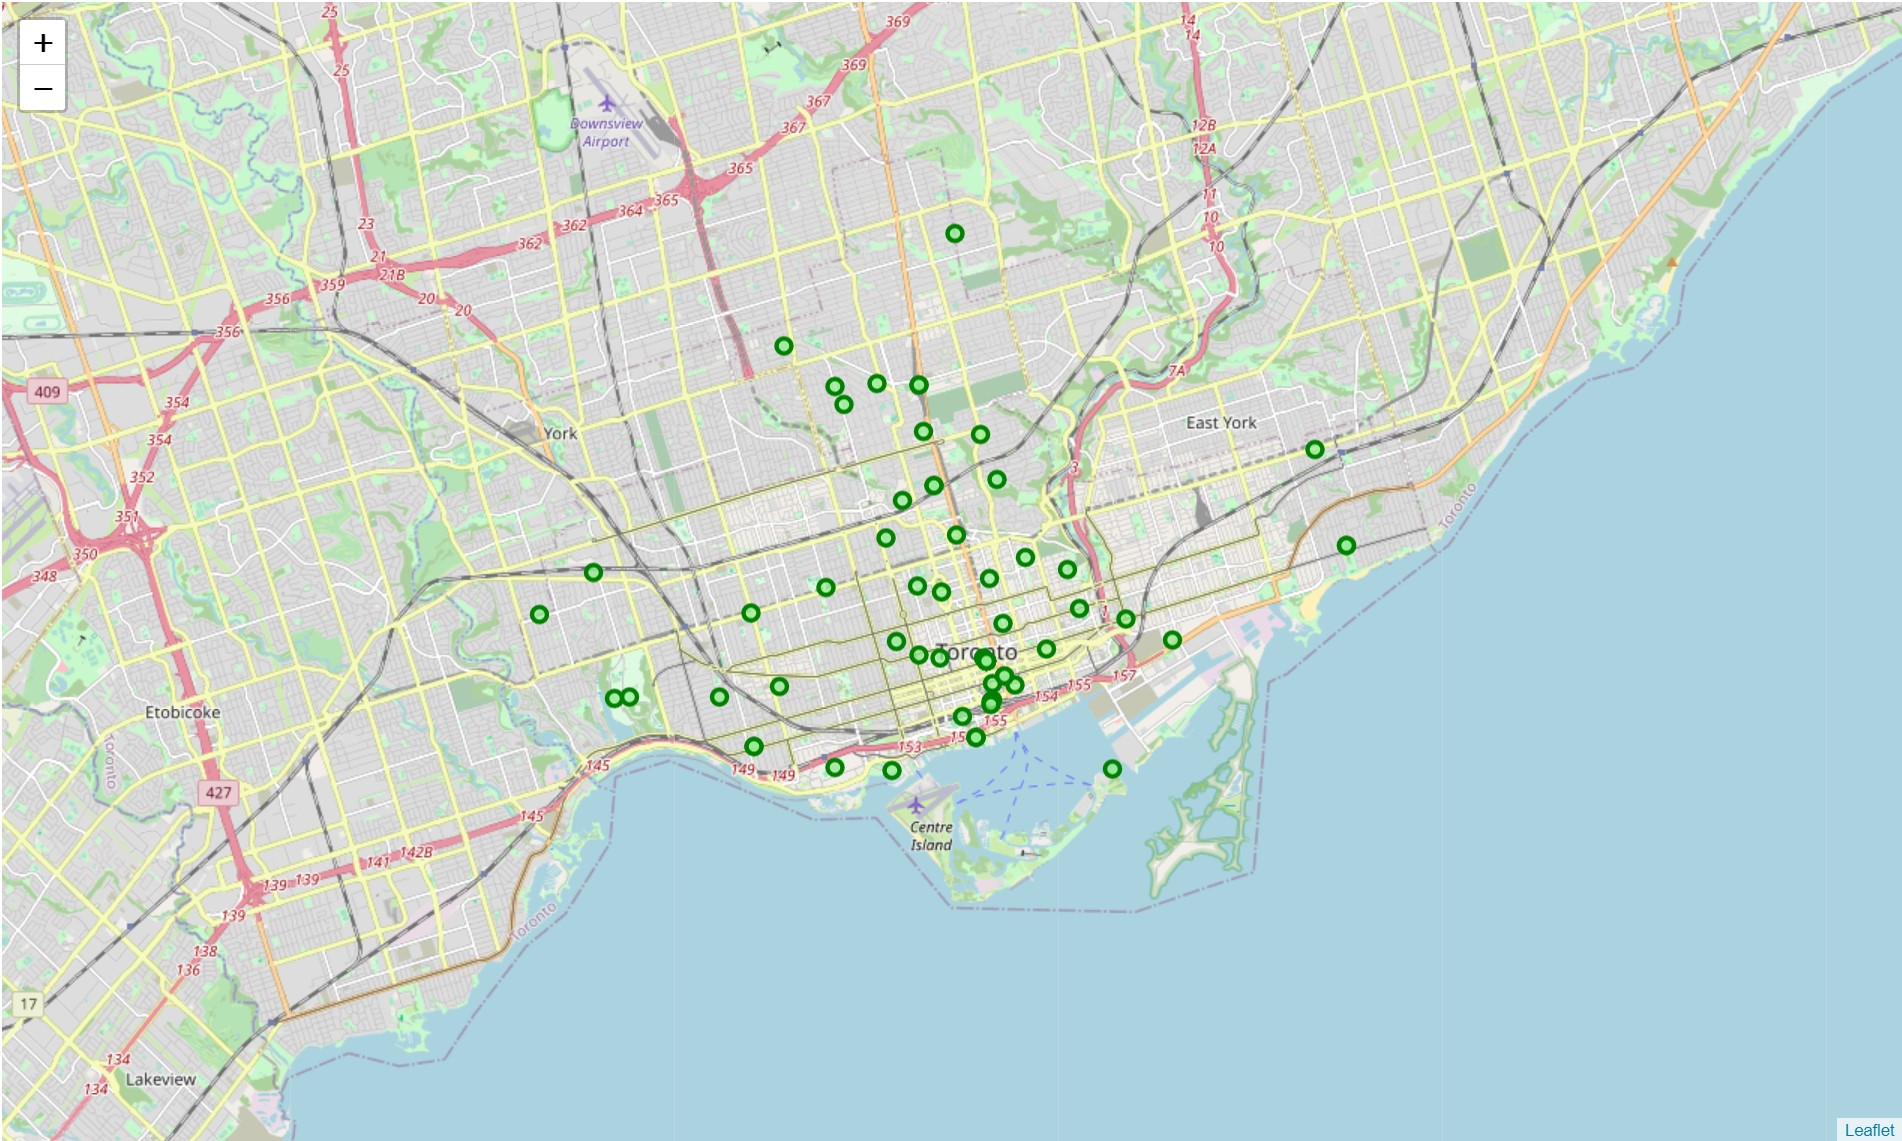

### 3.1 Create a List of Nearby Venues for All Neighbourhoods from Boroughs with 'Toronto' in Their Name

I will perform a more compact version of the suggested analyses as in the New York neighbourhood clustering and analyis lab (NY lab). We will therefore begin with getting a list of nearby venues for all of the neighbourhoods in data frame neigbourhoods5, which is for all neighbourhoods in boroughs containing 'Toronto' in their name. 

Now let's start with some work using Foursquare and first begin with assigning our credentials to variables and some definitions. I use the same API version as in the New York exercise.

In [24]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' #  Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Now we will find the max. 100 top venues 500 m around each neighbourhood and use Foursquare API calls to get the data. From the beginning we will limit ourselves to get only the most important data, which are the names, types, and the coordinates of the venues. We use an adapted version of the code form the NY lab for this.

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name) # Success control prints each of the neighbourhood names a
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue, see above
        
       
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue',
                  'Venue Category',           
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

toronto_venues = getNearbyVenues(names=neighbourhoods5['Neighbourhood'],
                                   latitudes=neighbourhoods5['Latitude'],
                                   longitudes=neighbourhoods5['Longitude']
                                  )

Regent Park
Harbourfront
Queen's Park
Ontario Provincial Government
Garden District
Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond
Adelaide
King
Dufferin
Dovercourt Village
Harbourfront East
Union Station
Toronto Islands
Little Portugal
Trinity
The Danforth West
Riverdale
Toronto Dominion Centre
Design Exchange
Brockton
Parkdale Village
Exhibition Place
India Bazaar
The Beaches West
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
Forest Hill Road Park
High Park
The Junction South
North Toronto West
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
University of Toronto
Harbord
Runnymede
Swansea
Moore Park
Summerhill East
Kensington Market
Chinatown
Grange Park
Summerhill West
Rathnelly
South Hill
Forest Hill SE
Deer Park
CN Tower
King and Spadina
Railway Lands
Harbourfront West
Bathurst Quay
South Niagara
Island airport
Rosedale
Stn A PO Boxes
Cabbagetown
First Canadian 

Now lets see what we got:

In [26]:
toronto_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0   Regent Park               43.660652               -79.360489   
1   Regent Park               43.660652               -79.360489   
2   Regent Park               43.660652               -79.360489   
3   Regent Park               43.660652               -79.360489   
4   Regent Park               43.660652               -79.360489   

                        Venue         Venue Category  Venue Latitude  \
0  Regent Park Aquatic Centre                   Pool       43.660600   
1             Sumach Espresso            Coffee Shop       43.658135   
2            Daniels Spectrum  Performing Arts Venue       43.660137   
3                  Thai To Go        Thai Restaurant       43.663418   
4             Paintbox Bistro             Restaurant       43.660050   

   Venue Longitude  
0       -79.361392  
1       -79.359515  
2       -79.361808  
3       -79.360710  
4       -79.362855

...and how big is the data frame?

In [27]:
toronto_venues.shape

(4489, 7)

Not bad around 60 venues per neighbourhood. Let's see how many unique categories we got:

In [28]:
len(toronto_venues['Venue Category'].unique())

267

So, we will have to consider 267 different types of venues for the continued analysis.

### 3.2 Find the 10 Most Popular Categories in Each Neighbourhood

To determine the most popular categories is in principle a frequency measurement, how many times do we find each venue category in each neighbourhood? The ten highest values then give us the ten most popular venue types in the respective neighbourhood. We begin with one hot encoding to see what we find in each neighbourhood.

In [29]:
# One hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighbourhood column to the data frame, get from toronto_venues
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# Move neighbourhood column from last to first position in the data frame
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

Let's see what the new data frame looks like:

In [30]:
toronto_onehot.head()

Neighbourhood  Accessories Store  Adult Boutique  African Restaurant  \
0   Regent Park                  0               0                   0   
1   Regent Park                  0               0                   0   
2   Regent Park                  0               0                   0   
3   Regent Park                  0               0                   0   
4   Regent Park                  0               0                   0   

   Airport Service  American Restaurant  Amphitheater  Animal Shelter  \
0                0                    0             0               0   
1                0                    0             0               0   
2                0                    0             0               0   
3                0                    0             0               0   
4                0                    0             0               0   

   Antique Shop  Aquarium  ...  University  Vegetarian / Vegan Restaurant  \
0             0         0  ...           0                              0   
1             0         0  ...           0                              0   
2             0         0  ...           0                              0   
3             0         0  ...           0                              0   
4             0         0  ...           0                              0   

   Video Game Store  Video Store  Vietnamese Restaurant  Whisky Bar  Wine Bar  \
0                 0            0                      0           0         0   
1                 0            0                      0           0         0   
2                 0            0                      0           0         0   
3                 0            0                      0           0         0   
4                 0            0                      0           0         0   

   Women's Store  Yoga Studio  Zoo  
0              0            0    0  
1              0            0    0  
2              0            0    0  
3              0            0    0  
4              0            0    0  

[5 rows x 268 columns]

...and how big is it?

In [31]:
toronto_onehot.shape

(4489, 268)

As expected, columns are unique categories + 1 and rows all venues. Next, create a new data frame, where we group rows by neighborhood and by taking the mean of the frequency of occurrence of each category to make things a little more manageable.

In [32]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

Neighbourhood  Accessories Store  Adult Boutique  \
0                                Adelaide           0.000000             0.0   
1                           Bathurst Quay           0.000000             0.0   
2                             Berczy Park           0.000000             0.0   
3                                Brockton           0.000000             0.0   
4   Business reply mail Processing Centre           0.000000             0.0   
..                                    ...                ...             ...   
70                       Underground city           0.000000             0.0   
71                          Union Station           0.000000             0.0   
72                  University of Toronto           0.000000             0.0   
73                         Victoria Hotel           0.000000             0.0   
74                              Yorkville           0.012195             0.0   

    African Restaurant  Airport Service  American Restaurant  Amphitheater  \
0                  0.0         0.000000             0.020000           0.0   
1                  0.0         0.076923             0.000000           0.0   
2                  0.0         0.000000             0.000000           0.0   
3                  0.0         0.000000             0.020000           0.0   
4                  0.0         0.000000             0.020000           0.0   
..                 ...              ...                  ...           ...   
70                 0.0         0.000000             0.020000           0.0   
71                 0.0         0.000000             0.032258           0.0   
72                 0.0         0.000000             0.000000           0.0   
73                 0.0         0.000000             0.020000           0.0   
74                 0.0         0.000000             0.024390           0.0   

    Animal Shelter  Antique Shop  Aquarium  ...  University  \
0              0.0          0.00       0.0  ...         0.0   
1              0.0          0.00       0.0  ...         0.0   
2              0.0          0.01       0.0  ...         0.0   
3              0.0          0.00       0.0  ...         0.0   
4              0.0          0.00       0.0  ...         0.0   
..             ...           ...       ...  ...         ...   
70             0.0          0.00       0.0  ...         0.0   
71             0.0          0.00       0.0  ...         0.0   
72             0.0          0.00       0.0  ...         0.0   
73             0.0          0.00       0.0  ...         0.0   
74             0.0          0.00       0.0  ...         0.0   

    Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                        0.010000          0.000000     0.000000   
1                        0.000000          0.000000     0.000000   
2                        0.010000          0.000000     0.000000   
3                        0.010000          0.000000     0.000000   
4                        0.010000          0.000000     0.000000   
..                            ...               ...          ...   
70                       0.010000          0.000000     0.000000   
71                       0.000000          0.000000     0.000000   
72                       0.000000          0.028571     0.000000   
73                       0.010000          0.000000     0.000000   
74                       0.012195          0.000000     0.012195   

    Vietnamese Restaurant  Whisky Bar  Wine Bar  Women's Store  Yoga Studio  \
0                     0.0         0.0  0.000000       0.000000     0.000000   
1                     0.0         0.0  0.000000       0.000000     0.000000   
2                     0.0         0.0  0.000000       0.000000     0.010000   
3                     0.0         0.0  0.000000       0.000000     0.000000   
4                     0.0         0.0  0.000000       0.000000     0.000000   
..                    ...         ...       ...            ...          ...   
70 

Very good 75 rows and 268 columns. This means that one neighbourhood does not have any popular venues, otherwise we would have  76 rows. Let's go on to find the 10 most popular types of venues in each neighbourhood and store these in a new data frame.

In [33]:
num_top_venues = 10 # Number of venues we are looking for - top ten

indicators = ['st', 'nd', 'rd'] # Indicators to be used in the column names of the new data frame

# A function for returning the desired number of top venues sorted in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


# Create cnumber of columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) # The first three columns
    except:
        columns.append('{}th Most Common Venue'.format(ind+1)) # The rest

# Create the new data frame
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

Let's see what we got.

In [34]:
neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue  \
0                               Adelaide           Coffee Shop   
1                          Bathurst Quay                   Gym   
2                            Berczy Park           Coffee Shop   
3                               Brockton           Coffee Shop   
4  Business reply mail Processing Centre           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café        Clothing Store                 Hotel   
1           Coffee Shop       Airport Service         Grocery Store   
2            Restaurant                  Café                 Hotel   
3                  Café        Clothing Store                 Hotel   
4                  Café        Clothing Store                 Hotel   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0            Restaurant    Italian Restaurant                   Gym   
1       Harbor / Marina                  Park                 Trail   
2    Seafood Restaurant                Bakery   Japanese Restaurant   
3            Restaurant    Italian Restaurant                   Gym   
4            Restaurant    Italian Restaurant                   Gym   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0             Gastropub            Poke Place                  Diner  
1           Pizza Place                Tunnel                   Café  
2    Italian Restaurant              Beer Bar           Cocktail Bar  
3             Gastropub            Poke Place                  Diner  
4             Gastropub            Poke Place                  Diner

Initial judgement by the fact that coffee shops and cafés are commonly in first or second place, is that people frequenting downtown Toronto seem to like coffee.

### 3.3 Clustering Neighbourhoods

Next we will create 5 clusters using k-means clustering and create a new data frame with the neighbourhoods, their cluster assignment, and 10 most popular venues for some additional analysis, quite like in the NY lab. Of course we should find out if 5 clusters is really the best number and play around with other parameters to optimize. We will skip this for the sake of time and reduced complexity.

Next, we will have to join the data frame with the cluster information with our neighbourhoods5 data frame to get the coordinates into the resulting data frame. We will use a right join (take the index from neighbourhoods_venues_sorted) to make sure that the neighborhood without venues doesn't creep back in, because this will interfere with the subsequent plotting of the map.

In [35]:
# Set the number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# Perform k-means clustering on tronto_grouped
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# Add cluster labels to the neighbourhoods_venues_sorted data frame
neighbourhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

toronto_merged = neighbourhoods5

# Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood. Perform right join to exclude neighbourhoods with 0 venues.
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how='right')

In [36]:
toronto_merged.head()

Neighbourhood   Latitude  Longitude  \
12                               Adelaide  43.651894 -79.381714   
65                          Bathurst Quay  43.633869 -79.403175   
8                             Berczy Park  43.647999 -79.375282   
25                               Brockton  43.651894 -79.381714   
74  Business reply mail Processing Centre  43.651894 -79.381714   

    Cluster Label 1st Most Common Venue 2nd Most Common Venue  \
12              4           Coffee Shop                  Café   
65              4                   Gym           Coffee Shop   
8               4           Coffee Shop            Restaurant   
25              4           Coffee Shop                  Café   
74              4           Coffee Shop                  Café   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
12        Clothing Store                 Hotel            Restaurant   
65       Airport Service         Grocery Store       Harbor / Marina   
8                   Café                 Hotel    Seafood Restaurant   
25        Clothing Store                 Hotel            Restaurant   
74        Clothing Store                 Hotel            Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
12    Italian Restaurant                   Gym             Gastropub   
65                  Park                 Trail           Pizza Place   
8                 Bakery   Japanese Restaurant    Italian Restaurant   
25    Italian Restaurant                   Gym             Gastropub   
74    Italian Restaurant                   Gym             Gastropub   

   9th Most Common Venue 10th Most Common Venue  
12            Poke Place                  Diner  
65                Tunnel                   Café  
8               Beer Bar           Cocktail Bar  
25            Poke Place                  Diner  
74            Poke Place                  Diner

Next, let's show the clusters on the Toronto map.

In [37]:
# Create a new map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# Set the color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add the cluster markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In case you can't see the trusted notebook, here is an embedded image of the map:

Obviusly our clustering approach has resulted in two larger clusters, one with two neigbourhoods and two single-nighbourhood clusters. It would make sense to optimize clustering, but as mentioned we will skip that.

### 3.4 Examine Clusters

Finally we will quickly inspect the clusters visually to see what defines them. Let's begin with the first, where the 'Cluster Label' is 0.

#### Mysterious Cluster

In [38]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 0, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
10                  Christie     Korean Restaurant           Coffee Shop   
46                Davisville      Sushi Restaurant           Coffee Shop   
35          Davisville North      Sushi Restaurant           Coffee Shop   
36  Forest Hill North & West           Pizza Place        Ice Cream Shop   
37     Forest Hill Road Park                 Trail                  Park   
59            Forest Hill SE             Locksmith           Auto Garage   
38                 High Park        Baseball Field          Amphitheater   
2               Queen's Park                  Park    Italian Restaurant   
57                 Rathnelly    Mexican Restaurant                  Park   
52           Summerhill East           Coffee Shop    Italian Restaurant   
56           Summerhill West           Coffee Shop    Italian Restaurant   
50                   Swansea        Baseball Field          Amphitheater   
41                 The Annex                  Café        Sandwich Place   
7                The Beaches   Japanese Restaurant                   Pub   
29          The Beaches West   Japanese Restaurant                   Pub   

     3rd Most Common Venue          4th Most Common Venue  \
10                     Pub                 Sandwich Place   
46      Italian Restaurant         Furniture / Home Store   
35      Italian Restaurant         Furniture / Home Store   
36       Korean Restaurant                   Burger Joint   
37           Jewelry Store               Sushi Restaurant   
59  Furniture / Home Store                     Astrologer   
38                 Dog Run                            Zoo   
2         Sushi Restaurant                        Theater   
57       French Restaurant  Vegetarian / Vegan Restaurant   
52        Sushi Restaurant                            Spa   
56        Sushi Restaurant                            Spa   
50                     Zoo                           Lake   
41       Indian Restaurant                     Donut Shop   
7          Thai Restaurant                            Bar   
29         Thai Restaurant                            Bar   

   5th Most Common Venue      6th Most Common Venue  \
10     Indian Restaurant             Ice Cream Shop   
46                   Pub                       Park   
35                   Pub                       Park   
36                   Spa  Middle Eastern Restaurant   
37                Museum               Neighborhood   
59     Accessories Store    New American Restaurant   
38                  Lake                     Garden   
2            Coffee Shop            College Theater   
57                  Café              Garden Center   
52     French Restaurant                       Café   
56     French Restaurant                       Café   
50                Garden       Other Great Outdoors   
41          Burger Joint          French Restaurant   
7              BBQ Joint             Sandwich Place   
29             BBQ Joint             Sandwich Place   

        7th Most Common Venue 8th Most Common Venue  \
10               Dessert Shop    Mexican Restaurant   
46  Middle Eastern Restaurant          Tennis Court   
35  Middle Eastern Restaurant          Tennis Court   
36                  Gastropub      Sushi Restaurant   
37                 Nail Salon           Music Venue   
59               Neighborhood            Nail Salon   
38       Other Great Outdoors                  Park   
2                        Bank          Burger Joint   
57                Shoe Repair          Liquor Store   
52                Pizza Place               Butcher   
56                Pizza Place               Butcher   
50                    Dog Run                  Park   
41  Middle Eastern Restaurant    Mexican Restaurant   
7                 Coffee Shop                  Park   
29                Coffee Shop                  Park   

            9th Most Common Venue 10th Most Common Venue  


I could not really see what defines this cluster, perhaps everything that does not fit into the other four? Because unlike those there is no real commonality among all of the members, although we obviously have some neighbourhoods that are so close to each other that they basically share the same popular venues. Definitely calls for better segmentation.

#### Fresh Air for the Kids Cluster

In [39]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 1, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
68      Rosedale                  Park            Playground   
58    South Hill            Playground                  Park   

   3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
68          Tennis Court             Music School          Neighborhood   
58          Music School  New American Restaurant          Neighborhood   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
68            Nail Salon           Music Venue           Music Store   
58            Nail Salon           Music Venue           Music Store   

   9th Most Common Venue 10th Most Common Venue  
68                Museum              Nightclub  
58                Museum           Noodle House

Park and playground rank very high in both neighbourhoods.

#### Island Cluster

In [40]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 2, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
18  Toronto Islands                 Beach                  Café   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
18         Boat or Ferry                  Pier          Music School   

      6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
18  New American Restaurant          Neighborhood            Nail Salon   

   9th Most Common Venue 10th Most Common Venue  
18           Music Venue            Music Store

What is unique here is that beach is in first place and also other water sports or water transport related venues, pier, boat or ferry, are in places 2 and 3.

#### Escape to the Park Cluster

In [41]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 3, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
51    Moore Park                  Park            Restaurant   

   3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
51     Accessories Store           Music Store  New American Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
51          Neighborhood            Nail Salon           Music Venue   

   9th Most Common Venue 10th Most Common Venue  
51          Music School           Noodle House

What caught my eye here was park in first place and an escape room in place 7.

#### Coffee Fans Cluster

In [42]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 4, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue  \
12                                       Adelaide           Coffee Shop   
65                                  Bathurst Quay                   Gym   
8                                     Berczy Park           Coffee Shop   
25                                       Brockton           Coffee Shop   
74          Business reply mail Processing Centre           Coffee Shop   
61                                       CN Tower                 Hotel   
70                                    Cabbagetown           Coffee Shop   
9                              Central Bay Street           Coffee Shop   
54                                      Chinatown                  Café   
73                           Church and Wellesley           Coffee Shop   
30                                 Commerce Court           Coffee Shop   
60                                      Deer Park           Coffee Shop   
24                                Design Exchange           Coffee Shop   
15                             Dovercourt Village           Coffee Shop   
14                                       Dufferin                   Bar   
27                               Exhibition Place        Soccer Stadium   
71                           First Canadian Place           Coffee Shop   
4                                 Garden District           Coffee Shop   
55                                    Grange Park           Coffee Shop   
48                                        Harbord           Coffee Shop   
1                                    Harbourfront           Coffee Shop   
16                              Harbourfront East           Coffee Shop   
64                              Harbourfront West           Coffee Shop   
28                                   India Bazaar           Coffee Shop   
67                                 Island airport           Coffee Shop   
53                              Kensington Market                  Café   
13                                           King           Coffee Shop   
62                               King and Spadina           Coffee Shop   
19                                Little Portugal                   Bar   
42                                  North Midtown           Coffee Shop   
40                             North Toronto West           Coffee Shop   
3                   Ontario Provincial Government           Coffee Shop   
44                                       Parkdale    Tibetan Restaurant   
26                               Parkdale Village    Tibetan Restaurant   
63                                  Railway Lands           Coffee Shop   
0                                     Regent Park           Coffee Shop   
11                                       Richmond           Coffee Shop   
22                                      Riverdale           Coffee Shop   
45                                   Roncesvalles           Coffee Shop   
34                                       Roselawn           Coffee Shop   
49                                      Runnymede                  Café   
5                                         Ryerson           Coffee Shop   
75  South Central Letter Processing Plant Toronto       Harbor / Marina   
66                                  South Niagara           Coffee Shop   
6                                  St. James Town           Coffee Shop   
69                                 Stn A PO Boxes           Coffee Shop   
32                                Studio District       Coworking Space   
21                              The Danforth West              Bus Line   
39                             The Junction South           Coffee Shop   
23                        Toronto Dominion Centre           Coffee Shop   
20                                        Trinity           Coffee Shop   
72                               Underground city           Coffee Shop   
17                                  Union Station           C

Here we find coffee shops in every neighbourhod, most often  in first or second place. Obviously some of the neighbourhoods are so close together that they have very similar to identical data regarding popular venues.

This concludes my work on this assignment.